# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import pydicom
import os

# Data preprocessing

In [2]:
train_df = pd.read_csv("./data/train.csv")

In [3]:
train_df

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   study_id                                1975 non-null   int64 
 1   spinal_canal_stenosis_l1_l2             1974 non-null   object
 2   spinal_canal_stenosis_l2_l3             1974 non-null   object
 3   spinal_canal_stenosis_l3_l4             1974 non-null   object
 4   spinal_canal_stenosis_l4_l5             1974 non-null   object
 5   spinal_canal_stenosis_l5_s1             1974 non-null   object
 6   left_neural_foraminal_narrowing_l1_l2   1973 non-null   object
 7   left_neural_foraminal_narrowing_l2_l3   1973 non-null   object
 8   left_neural_foraminal_narrowing_l3_l4   1973 non-null   object
 9   left_neural_foraminal_narrowing_l4_l5   1973 non-null   object
 10  left_neural_foraminal_narrowing_l5_s1   1973 non-null   object
 11  righ

In [5]:
train_label_coordinates_df = pd.read_csv("./data/train_label_coordinates.csv")

In [6]:
train_label_coordinates_df

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602
...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333


Let's add a column to train_label_coordinates_df with the severity that is included in the train_df

In [7]:
# Create a mapping from the level to the corresponding column name in df1
level_to_column = {
    'Spinal Canal StenosisL1/L2': 'spinal_canal_stenosis_l1_l2',
    'Spinal Canal StenosisL2/L3': 'spinal_canal_stenosis_l2_l3',
    'Spinal Canal StenosisL3/L4': 'spinal_canal_stenosis_l3_l4',
    'Spinal Canal StenosisL4/L5': 'spinal_canal_stenosis_l4_l5',
    'Spinal Canal StenosisL5/S1': 'spinal_canal_stenosis_l5_s1',
    'Left Neural Foraminal NarrowingL1/L2': 'left_neural_foraminal_narrowing_l1_l2',
    'Left Neural Foraminal NarrowingL2/L3': 'left_neural_foraminal_narrowing_l2_l3',
    'Left Neural Foraminal NarrowingL3/L4': 'left_neural_foraminal_narrowing_l3_l4',
    'Left Neural Foraminal NarrowingL4/L5': 'left_neural_foraminal_narrowing_l4_l5',
    'Left Neural Foraminal NarrowingL5/S1': 'left_neural_foraminal_narrowing_l5_s1',
    'Right Neural Foraminal NarrowingL1/L2': 'right_neural_foraminal_narrowing_l1_l2',
    'Right Neural Foraminal NarrowingL2/L3': 'right_neural_foraminal_narrowing_l2_l3',
    'Right Neural Foraminal NarrowingL3/L4': 'right_neural_foraminal_narrowing_l3_l4',
    'Right Neural Foraminal NarrowingL4/L5': 'right_neural_foraminal_narrowing_l4_l5',
    'Right Neural Foraminal NarrowingL5/S1': 'right_neural_foraminal_narrowing_l5_s1',
    'Left Subarticular StenosisL1/L2': 'left_subarticular_stenosis_l1_l2',
    'Left Subarticular StenosisL2/L3': 'left_subarticular_stenosis_l2_l3',
    'Left Subarticular StenosisL3/L4': 'left_subarticular_stenosis_l3_l4',
    'Left Subarticular StenosisL4/L5': 'left_subarticular_stenosis_l4_l5',
    'Left Subarticular StenosisL5/S1': 'left_subarticular_stenosis_l5_s1',
    'Right Subarticular StenosisL1/L2': 'right_subarticular_stenosis_l1_l2',
    'Right Subarticular StenosisL2/L3': 'right_subarticular_stenosis_l2_l3',
    'Right Subarticular StenosisL3/L4': 'right_subarticular_stenosis_l3_l4',
    'Right Subarticular StenosisL4/L5': 'right_subarticular_stenosis_l4_l5',
    'Right Subarticular StenosisL5/S1': 'right_subarticular_stenosis_l5_s1',
}

# Add a new column in train_label_coordinates_df for the severity
train_label_coordinates_df['severity'] = train_label_coordinates_df.apply(lambda row: train_df.loc[train_df['study_id'] == row['study_id'], level_to_column[row['condition'] + row['level']]].values[0], axis=1)


Let's also get the image paths into the df

In [8]:
train_label_coordinates_df["image_path"] = train_label_coordinates_df.apply(lambda row: f"./data/train_images/{row['study_id']}/{row['series_id']}/{row['instance_number']}.dcm", axis=1)

In [59]:
train_label_coordinates_df['coordinates'] = train_label_coordinates_df.apply(lambda row: (round(row['x'], 6), rourow['y']), axis=1)

In [75]:
train_label_coordinates_df

,study_id,series_id,instance_number,condition,level,x,y,severity,image_path,coordinates
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,./data/train_images/4003253/702807833/8.dcm,"(322.83185840707966, 227.9646017699115)"
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,./data/train_images/4003253/702807833/8.dcm,"(320.57142857142856, 295.7142857142857)"
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,./data/train_images/4003253/702807833/8.dcm,"(323.03030303030306, 371.8181818181818)"
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,./data/train_images/4003253/702807833/8.dcm,"(335.2920353982301, 427.3274336283186)"
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,./data/train_images/4003253/702807833/8.dcm,"(353.4159292035398, 483.9646017699115)"
...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,Normal/Mild,./data/train_images/4290709089/4237840455/11.dcm,"(219.46594005449592, 97.83106267029972)"
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,Normal/Mild,./data/train_images/4290709089/4237840455/12.dcm,"(205.3405994550409, 140.20708446866485)"
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,Normal/Mild,./data/train_images/4290709089/4237840455/12.dcm,"(202.724795640327, 181.01362397820165)"
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,Normal/Mild,./data/train_images/4290709089/4237840455/12.dcm,"(202.9333333333333, 219.7333333333333)"


# Model

Start with creating a custom dataset class

In [70]:
class SpineDataset(Dataset):
    def __init__(self, dicom_dir, coordinates, labels, transform=None):
        self.dicom_files = dicom_dir.tolist()
        self.coordinates = coordinates
        self.labels = labels
        self.transform = transform
        self.condition_mapping = {
            'Normal/Mild': 0,
            'Moderate': 1,
            'Severe': 2
        }

    def __len__(self):
        return len(self.dicom_files)

    def __getitem__(self, idx):
        dicom_path = os.path.join(self.dicom_files[idx])
        dicom = pydicom.dcmread(dicom_path)
        image = dicom.pixel_array
        image = Image.fromarray(image).convert("RGB")
        plt.imshow(image)

        if self.transform:
            image = self.transform(image)

        coordinates = self.coordinates[idx]

        # TODO: Fix so this has the correct severity for the file
        label = self.labels[idx]
        
        return image, coordinates, label

In [71]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5))
])

In [72]:
dataset = SpineDataset(train_label_coordinates_df["image_path"], train_label_coordinates_df["coordinates"], train_label_coordinates_df["severity"], transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

(tensor([[[-0.9922, -0.9686, -0.9686,  ..., -0.9843, -0.9922, -0.9922],
          [-0.9686, -0.8902, -0.8824,  ..., -0.9216, -0.9373, -0.9686],
          [-0.9765, -0.9059, -0.8902,  ..., -0.9137, -0.8980, -0.9529],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.9922, -0.9686, -0.9686,  ..., -0.9843, -0.9922, -0.9922],
          [-0.9686, -0.8902, -0.8824,  ..., -0.9216, -0.9373, -0.9686],
          [-0.9765, -0.9059, -0.8902,  ..., -0.9137, -0.8980, -0.9529],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
         [[-0.9922, -0.9686, -0.9686,  ..., -0.9843, -0.9922, -0.9922],
          [-0.9686, -0.8902,

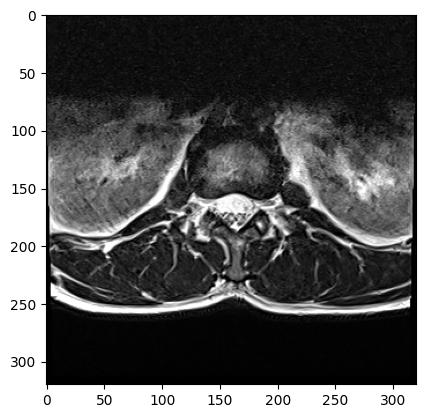

In [73]:
dataset[150]